In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
# ----------------------------
# 1. Load dataset
# ----------------------------
df = pd.read_csv("..\\data\\HR_cleaned_dataset.csv")

# Define X and y
X = df.drop('left', axis=1)   # 18 predictors
y = df['left']                # target variable
print(X.shape, y.shape)

(11991, 18) (11991,)


In [3]:
# ----------------------------
# 2. Train-test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
# ----------------------------
# 3. Build pipeline
# ----------------------------

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

# ----------------------------
# 4. Hyperparameter tuning (Grid Search)
# ----------------------------
param_grid = {
    'knn__n_neighbors': list(range(3, 31, 2)),  # try odd k up to 30
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',   
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19,
                                              21, 23, 25, 27, 29],
                         'knn__weights': ['uniform', 'distance']},
             scoring='f1')

In [5]:
# ----------------------------
# 5. Evaluation
# ----------------------------
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Predict on test set
y_pred = grid_search.predict(X_test)
y_proba = grid_search.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))

Best Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}
Best CV Score: 0.8581448264355102

Confusion Matrix:
 [[1932   69]
 [  37  361]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      2001
           1       0.84      0.91      0.87       398

    accuracy                           0.96      2399
   macro avg       0.91      0.94      0.92      2399
weighted avg       0.96      0.96      0.96      2399

AUC Score: 0.9605435975479597


In [6]:
# Predict on train set
y_train_pred = grid_search.predict(X_train)
y_train_proba = grid_search.predict_proba(X_train)[:, 1]  # Probabilities for the positive class

print("\nConfusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))


Confusion Matrix:
 [[7999    0]
 [   0 1593]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7999
           1       1.00      1.00      1.00      1593

    accuracy                           1.00      9592
   macro avg       1.00      1.00      1.00      9592
weighted avg       1.00      1.00      1.00      9592



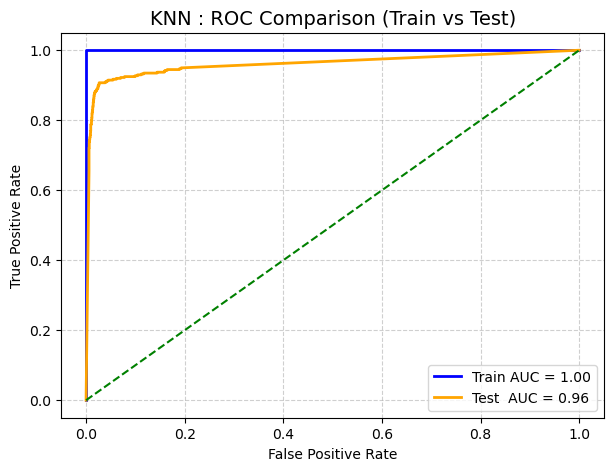

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# ROC curve for test
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba)
roc_auc_test = auc(fpr_test, tpr_test)

# ROC curve for train
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
roc_auc_train = auc(fpr_train, tpr_train)

# Plot ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr_train, tpr_train, color='blue', lw=2,
         label=f"Train AUC = {roc_auc_train:.2f}")
plt.plot(fpr_test, tpr_test, color='orange', lw=2,
         label=f"Test  AUC = {roc_auc_test:.2f}")

# Random baseline
plt.plot([0, 1], [0, 1], color='green', linestyle='--')

# Labels and legend
plt.title("KNN : ROC Comparison (Train vs Test)", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

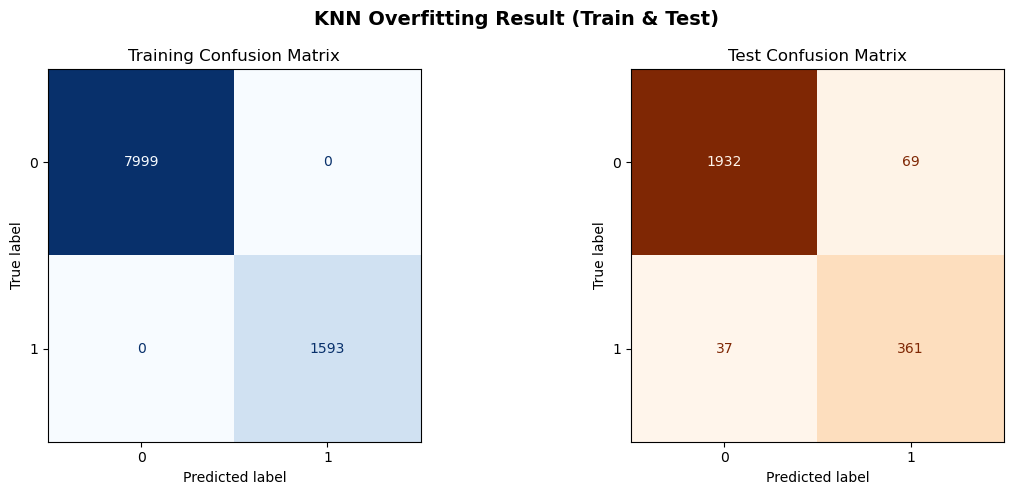

In [8]:
cm_test = confusion_matrix(y_test, y_pred )
cm_train = confusion_matrix(y_train, y_train_pred)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(cm_test).plot(ax=axes[1], cmap="Oranges", colorbar=False)
axes[1].set_title("Test Confusion Matrix")

ConfusionMatrixDisplay(cm_train).plot(ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title("Training Confusion Matrix")

plt.suptitle("KNN Overfitting Result (Train & Test)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()
